# Numpyro version

This is about 100x faster! and the code is nicer! joy oh joy!

# The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

This notebook will be dedicated to estimating parameters within some __simulated data__.

In [1]:
# %config IPCompleter.use_jedi = False
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from jax.random import PRNGKey
from numpyro.infer import MCMC, NUTS, Predictive

# import pyro.infer
# import pyro.optim
# import pyro.distributions as dist
# from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

import siuba as s
from siuba import _


from dfply import mutate, X
# %run -i 'model_helpers.py'
# %run -i 'models.py'

from lib.helpers import *
from lib.models import *
from lib.simdata import make_sim_data_bs_avg, make_sim_data_ptn_avg

## Simulate data

## create and fit model

Easiest to focus on fitting for a single participant

In [33]:
## 6/21/22, 3:26 PM
## something wong with the sim code, maybe should just start over???

n_participants, n_blocks, n_conditions = 50, 3, 10

params = {
    "N_base": {k: np.exp(1 + np.random.normal(1, .5)) for k in range(0,n_participants)},
    "N_delta": {k: np.exp(np.random.normal(1, .5)) for k in range(0,n_participants)},
    "beta": {k: np.random.beta(5,1) for k in range(0, n_participants)},
}


sim_data = make_sim_data_bs_avg(n_participants, n_conditions, params, 15.)
sim_data

,ID,querytype,condition,conjdisj_trial,N_base,N_delta,beta,theta,N,implied_d,prob,estimate
0,0,A,0,0,17.356058,2.591317,0.673640,"[0.13217380632048456, 0.14301942209661953, 0.3...",19.947375,0.031634,0.275193,0.341589
1,0,AandB,0,1,17.356058,2.591317,0.673640,"[0.13217380632048456, 0.14301942209661953, 0.3...",17.356058,0.036017,0.132174,0.102072
2,0,AandnotB,0,1,17.356058,2.591317,0.673640,"[0.13217380632048456, 0.14301942209661953, 0.3...",17.356058,0.036017,0.143019,0.168754
3,0,AgB,0,0,17.356058,2.591317,0.673640,"[0.13217380632048456, 0.14301942209661953, 0.3...",19.947375,0.031634,0.267985,0.413185
4,0,AgnotB,0,0,17.356058,2.591317,0.673640,"[0.13217380632048456, 0.14301942209661953, 0.3...",19.947375,0.031634,0.282209,0.512799
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49,notAorB,9,1,9.818724,1.930061,0.894122,"[0.029628346788960792, 0.0992866642576289, 0.6...",9.818724,0.077033,0.970372,0.984936
9996,49,notAornotB,9,1,9.818724,1.930061,0.894122,"[0.029628346788960792, 0.0992866642576289, 0.6...",9.818724,0.077033,0.275330,0.470993
9997,49,notB,9,0,9.818724,1.930061,0.894122,"[0.029628346788960792, 0.0992866642576289, 0.6...",11.748785,0.066050,0.275330,0.144974
9998,49,notBgA,9,0,9.818724,1.930061,0.894122,"[0.029628346788960792, 0.0992866642576289, 0.6...",11.748785,0.066050,0.770171,0.641046


In [34]:
def bayesian_sampler_complex_mlm_d(data, y=None):

    # parameterized in terms of d and d' for comparison of model fit

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0]

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    d_base_pop = numpyro.sample("d_base_pop", dist.Normal(-1.0, 1.0))
    d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0, .5)) # bias toward lower values for non conj/disj trials
    d_base_sd = numpyro.sample("d_base_sd", dist.LogNormal(-1., 1.)) # was halfcauchy(1)
    d_delta_sd = numpyro.sample("d_delta_sd", dist.LogNormal(-1., 1.)) # approx uniform altogether we hope

    # subject-level parameters/priors
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base_r", dist.Normal(0, 1))
        d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, 1))

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    d_lin = (d_base_pop +
             d_bases[subj]*d_base_sd +
             jnp.exp(d_delta_pop + d_delta_sd*d_deltas[subj])*conjdisj
            )  # exp() constrains d_delta to be positive
    d = sigmoid(d_lin)/3.0 # require this be in [0, 1/3]

    numpyro.deterministic("d_subj", sigmoid(d_base_pop + d_bases*d_base_sd)/3.)
    numpyro.deterministic("d_prime_subj",
                          sigmoid(d_base_pop +
                                  d_bases*d_base_sd +
                                  jnp.exp(d_delta_pop + d_deltas*d_delta_sd)
                                 )/3.
                         )

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)

    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)

    return yhat

In [35]:
X_data, y_data = make_model_data(sim_data) # see data_helpers.py
# X_data, y_data

In [5]:
kernel_bs_complex_mlm = NUTS(bayesian_sampler_complex_mlm_d, target_accept_prob=.80) # need the higher prob and more samples to get good rhats
mcmc_bs_mlm = MCMC(kernel_bs_complex_mlm,
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_bs_mlm.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 4000/4000 [02:27<00:00, 27.03it/s, 31 steps of size 1.31e-01. acc. prob=0.91] 


In [62]:
from numpyro.infer.svi import SVI
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoLaplaceApproximation, AutoDAIS, AutoBNAFNormal, AutoIAFNormal, AutoMultivariateNormal
from numpyro.optim import Adam
from numpyro.infer import Trace_ELBO, TraceGraph_ELBO

guide = AutoBNAFNormal(bayesian_sampler_complex_mlm_d)
optimizer = Adam(1e-3)
loss = TraceGraph_ELBO(num_particles=1)
svi = SVI(bayesian_sampler_complex_mlm_d, guide, optimizer, loss)

In [ ]:
svi_result = svi.run(random.PRNGKey(1), 7_000, X_data, y_data)

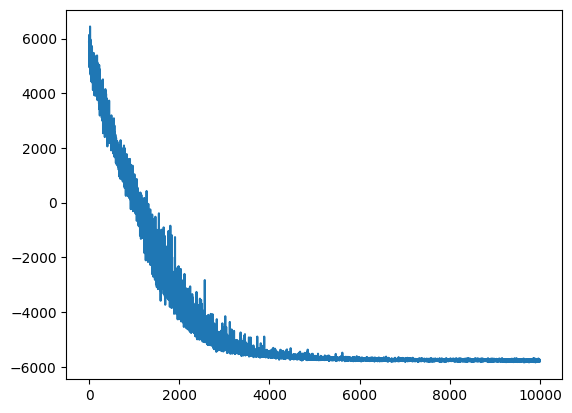

In [48]:
import matplotlib.pyplot as plt
plt.plot(svi_result.losses)

In [49]:
def arviz_from_svi(model, guide, params, *args, obs_data=None, num_samples = 1_000):
    
    posterior_samples = guide.sample_posterior(random.PRNGKey(1), params=params, sample_shape=(num_samples,))
    samples_posterior_predictive = Predictive(model=model, posterior_samples=posterior_samples)(random.PRNGKey(1), *args)
    samples_prior_predictive = Predictive(model=model, params=None, num_samples=num_samples)(random.PRNGKey(1), *args)

    return az.from_dict(
        {k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
        prior = {k: np.expand_dims(v, 0) for k, v in samples_prior_predictive.items()},
        posterior_predictive = {k: np.expand_dims(v, 0) for k, v in samples_posterior_predictive.items()},
        observed_data = {"yhat": obs_data}
    )

az_data_bs = arviz_from_svi(bayesian_sampler_complex_mlm_d, guide, svi_result.params, X_data, obs_data = y_data, num_samples=2_000)

<AxesSubplot:xlabel='yhat / yhat'>

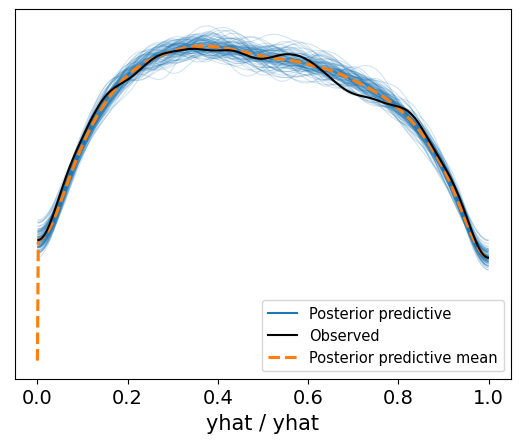

In [50]:
az.plot_ppc(az_data_bs, num_pp_samples=100)

In [6]:
# mcmc_bs_mlm.print_summary()
# az_data_bs = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm_d, X_data)

In [51]:
import scipy
## pull out samples for each individual and match back up with data
## see if we're recovering the original parameters ...

def extract_samples(z, var_name, prior=False):
    if prior:
        x1 = pd.DataFrame(np.array(z.prior[var_name]))
    else:
        x1 = pd.DataFrame(np.array(z.posterior[var_name]))
    
    x1 = x1.reset_index() >> s.gather("draw", "value", -_.index) >> s.mutate(var = var_name)
    
    return(x1)

def dist_to_df(az_data, var_list, prior=False):
    # note variables must have same raw dimensions
    z = az_data.stack(sample=['chain','draw'])
    
    df_list = [extract_samples(z, v, prior) for v in var_list]
    df = pd.concat(df_list)
    
    df = df >> s.spread("var", "value")
    
    return(df)


In [52]:
def posterior_to_df_mlm(az_data, fixed_list, random_list):
    fixeds = dist_to_df(az_data, fixed_list) >> s.mutate(draw = _.index) >> s.select(-_.index)
    randoms = dist_to_df(az_data, random_list)

    df_posterior = pd.merge(fixeds, randoms, on="draw") >> s.rename(ID = _.index)
    
    return(df_posterior)


def prior_to_df_mlm(az_data, fixed_list, random_list):
    fixeds = dist_to_df(az_data, fixed_list, prior=True) >> s.mutate(draw = _.index) >> s.select(-_.index)
    randoms = dist_to_df(az_data, random_list, prior=True)

    df_prior = pd.merge(fixeds, randoms, on="draw") >> s.rename(ID = _.index)
    
    return(df_prior)
    
    
df_posterior = posterior_to_df_mlm(
    az_data_bs, 
    ["d_base_pop", "d_delta_pop", "d_base_sd", "d_delta_sd"],
    ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj"]
)

In [53]:
# df_posterior >> s.filter(_.ID==0)
df_posterior

,draw,d_base_pop,d_base_sd,d_delta_pop,d_delta_sd,ID,d_base_r,d_delta_r,d_prime_subj,d_subj
0,0,-0.576949,0.848014,-1.796899,0.621039,0,-0.673968,-1.029838,0.085705,0.080255
1,0,-0.576949,0.848014,-1.796899,0.621039,1,-1.040235,-0.457350,0.069485,0.062869
2,0,-0.576949,0.848014,-1.796899,0.621039,2,0.196323,0.541804,0.151846,0.132934
3,0,-0.576949,0.848014,-1.796899,0.621039,3,-1.398112,0.772270,0.061072,0.048823
4,0,-0.576949,0.848014,-1.796899,0.621039,4,-0.038204,-0.573436,0.126379,0.117403
...,...,...,...,...,...,...,...,...,...,...
99995,1999,-0.379134,0.953081,-1.726092,0.476524,45,-1.849311,-0.162544,0.040548,0.035037
99996,1999,-0.379134,0.953081,-1.726092,0.476524,46,1.253359,-0.439746,0.241024,0.231088
99997,1999,-0.379134,0.953081,-1.726092,0.476524,47,-0.461120,-1.693516,0.107726,0.102019
99998,1999,-0.379134,0.953081,-1.726092,0.476524,48,-1.470978,0.327402,0.057260,0.048056


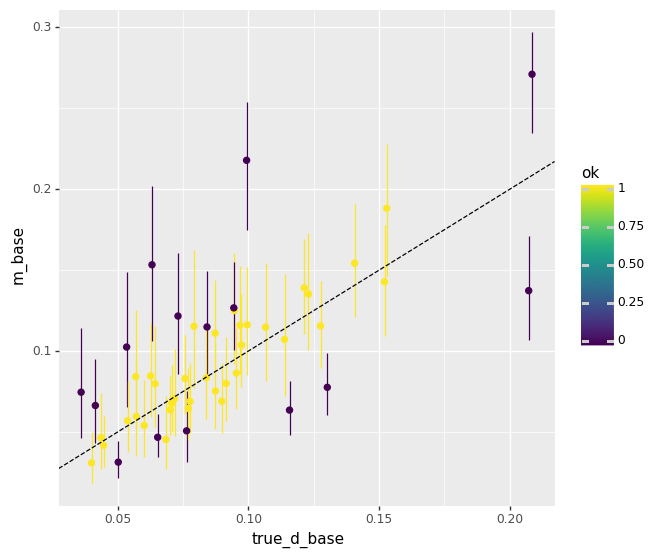

<ggplot: (8771496402541)>

In [61]:
from plotnine import * 

from scipy.special import expit

x = (
    df_posterior >>
    s.mutate(d_base = _.d_base_pop + _.d_base_r * _.d_base_sd, 
             d_prime = _.d_base + np.exp(_.d_delta_pop + _.d_delta_r *  _.d_delta_sd)
         ) >> 
    s.group_by("ID") >>
    # s.summarize(
    #     m_base = _.d_subj.mean(),
    #     ll_base = _.d_subj.quantile(.025),
    #     ul_base = _.d_subj.quantile(.975)
    # )
    s.summarize(
        m_base = expit(_.d_base.mean())/3.,
        ll_base = expit(_.d_base.quantile(.025))/3.,
        ul_base = expit(_.d_base.quantile(.975))/3.,
        m_prime = expit(_.d_prime.mean())/3.,
        ll_prime = expit(_.d_prime.quantile(.025))/3.,
        ul_prime = expit(_.d_prime.quantile(.975))/3.
    )
)


subj_params = (
    pd.DataFrame(params).reset_index() >> 
    s.rename(ID = _.index) >>
    s.mutate(
        true_d_base = _.beta / (_.N_base + 2*_.beta),
        true_d_prime = _.beta / (_.N_base + _.N_delta + 2*_.beta),
    )
)


(
    pd.merge(x, subj_params, on = "ID") >> 
    s.mutate(ok = s.if_else(_.ll_base < _.true_d_base, s.if_else(_.ul_base > _.true_d_base, 1, 0), 0)) >>
    ggplot(aes(x="true_d_base", y = "m_base", ymin="ll_base", ymax="ul_base", color="ok")) + 
    geom_pointrange() +
    geom_abline(intercept=0, slope=1, linetype="dashed") +
    # coord_flip() +
    theme(aspect_ratio=1)
)

Lots of uncertainy in the results for individual subject-level values with only 2 conditions. Plus, pretty clealry some bias to the estimates, biased to estiamte lower than actual values for d. Wonder if the population-level and sd estimates are right? Presumably they're also biased.

If we hypothetically icnrease to 10, then it looks unbiased and more confident. SVI approximation is overconfident but unbiased.

# PT+N simulations

should be working

In [180]:
d_bases = np.random.beta(1,3, n_participants)/2.
d_deltas = np.random.beta(1,3, n_participants)/2. * ((1-d_bases) - .5)


params_ptn = {
    "d_base": {k: d_bases[k] for k in range(0,n_participants)},
    "d_delta": {k: d_deltas[k] for k in range(0,n_participants)},
    "k":15
}

sim_data2 = make_sim_data_ptn_avg(n_participants, params_ptn)

X_data, y_data = make_model_data(sim_data2) # see data_helpers.py

In [181]:
mcmc_ptn = MCMC(NUTS(PTN_complex_mlm, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 4000/4000 [01:16<00:00, 52.45it/s, 31 steps of size 1.40e-01. acc. prob=0.88] 


In [ ]:
# mcmc_ptn.print_summary()

3/24/21, 4:58 PM: Working! (earlier problem was simulation bug)

In [182]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex_mlm, X_data)

In [183]:
df_posterior2 = posterior_to_df_mlm(
    az_data_ptn, 
    ["d_base_pop", "d_delta_pop", "d_base_sd", "d_delta_sd"],
    ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj"]
)

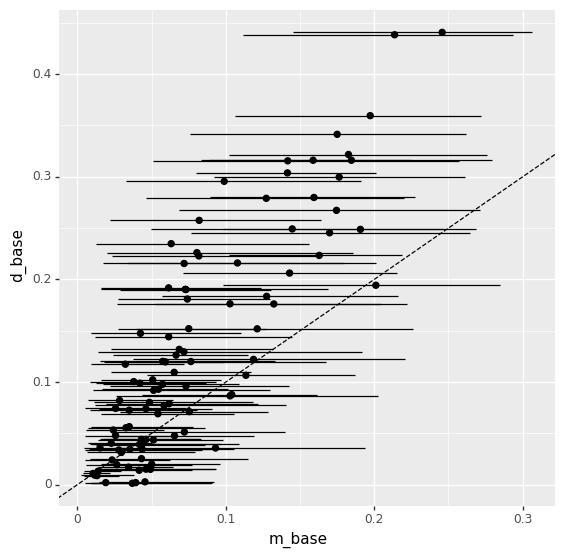

<ggplot: (8730819263591)>

In [184]:
x = (
    df_posterior2 >>
    s.mutate(d_base = _.d_base_pop + _.d_base_r * _.d_base_sd, 
             d_prime = _.d_base + np.exp(_.d_delta_pop + _.d_delta_r *  _.d_delta_sd)
         ) >> 
    s.group_by("ID") >>
    s.summarize(
        m_base = expit(_.d_base.mean())/3.,
        ll_base = expit(_.d_base.quantile(.025))/3.,
        ul_base = expit(_.d_base.quantile(.975))/3.,
        m_prime = expit(_.d_prime.mean())/3.,
        ll_prime = expit(_.d_prime.quantile(.025))/3.,
        ul_prime = expit(_.d_prime.quantile(.975))/3.
    )
)


subj_params = (
    pd.DataFrame(params_ptn).reset_index() >> 
    s.rename(ID = _.index) >>
    s.mutate(
        true_d_prime = _.d_base + _.d_delta,
    )
)


(
    pd.merge(x, subj_params, on = "ID") >> 
    ggplot(aes(x="d_base", y = "m_base", ymin="ll_base", ymax="ul_base")) + 
    geom_pointrange() +
    geom_abline(intercept=0, slope=1, linetype="dashed") +
    coord_flip() +
    theme(aspect_ratio=1)
)

## PROBLEM

8/9/22, 4:29 PM

Things aren't perfect but my concern was mostly overblown. It was indexing crap as always. Though things genuinely don't look that great in the PTN case. So will need to rework the simulation code probably to match the BS model.